# Comment Spam Classification

## Objective

Make a classifier to decide a comments whether it’s spam or not. You can use file "Comment Spam.xls" as Data Training. In the field Class, 0 means not spam and 1 means spam.

## Table of Contents
**1. Load and Check Data**

    1.1 Importing Data
    1.2 Check Duplicates
    1.3 Replace strange stirng
    1.4 Denoise Data
**2. Data Exploration**

    2.1 Add Length Column
    2.2 Check Distribution
        - 2.2.1 Class Distribution
        - 2.2.2 Class vs Length Distribution
**3. Data Modelling & Prediction**

    3.1 Logistic Regression
        - 3.1.1 Prediction
        - 3.1.2 Confusion Matrix
    3.2 Multinomial Naive Bayes
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.3 Random Forest Classifier
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.4 Stochastic Gradient Descent
        - 3.2.1 Prediction
        - 3.2.2 Confusion Matrix
    3.5 Summary
**4. Conclusion**

## 1. Load and Check Data

### 1.1 Importing Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_excel('data/01_raw/Comment Spam.xls', index_col = 0)

df['Class'] = df['Class'].map({0:'not spam', 1:'spam'}) #rename the binary into spam or not spam, 1: spam

In [4]:
df.head()

,Comment,Class
No,,
1,this song is racist,not spam
2,and how many subscribers compared to her over ...,spam
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,spam
4,well done shakira,not spam
5,:D subscribe to me for daily vines,spam


### 1.2 Check duplicates

In [5]:
# copy the original, to be safe
df_clean = df.copy()

In [6]:
df_clean.groupby('Class').describe()

Comment                                               
           count unique                                top freq
Class                                                          
not spam     631    612                        Shakira :-*    4
spam         669    550  Check out this video on YouTube:﻿   74

**There are some duplicate entries for each Class, 19 for not spam, 81 for spam. Let's remove them by category**

In [7]:
spam = df_clean[df_clean['Class'] == 'spam'].copy()
not_spam = df_clean[df_clean['Class'] == 'not spam'].copy()

frames = [spam, not_spam]

In [8]:
#remove duplicate for each category
for frame in frames:
    frame.drop_duplicates(subset='Comment', inplace=True)

In [9]:
df_clean = pd.concat(frames)
df_clean.groupby('Class').describe()

Comment                                                            \
           count unique                                                top   
Class                                                                        
not spam     612    612  they said this video are not deserve 2billion ...   
spam         550    550  Hey, join me on tsū, a publishing platform whe...   

               
         freq  
Class          
not spam    1  
spam        1

**duplicates have been removed**

### 1.3 Replace strange string

In [10]:
df_clean.head()

,Comment,Class
No,,
2,and how many subscribers compared to her over ...,spam
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,spam
5,:D subscribe to me for daily vines,spam
6,"Part 2. Holy Mary, pray for us Holy Mother of ...",spam
7,"I really can&#39;t comprehend Miley Cyrus , s...",spam


**There like strange value like "&#39 ;" let's replace them into "'"**

In [11]:
def replace_strange_string(text):
    return text.replace("&#39;", "'")

In [12]:
df_clean['Comment'] = df_clean['Comment'].apply(lambda x: replace_strange_string(x))

In [13]:
df_clean.head()

,Comment,Class
No,,
2,and how many subscribers compared to her over ...,spam
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,spam
5,:D subscribe to me for daily vines,spam
6,"Part 2. Holy Mary, pray for us Holy Mother of ...",spam
7,"I really can't comprehend Miley Cyrus , she a...",spam


### 1.4 Denoise Text

Remove noise like html tag

In [14]:
# import the library
import re, string, unicodedata
from bs4 import BeautifulSoup

# suppress bs4 warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [15]:
def strip_html(text):
    """remove html markup"""
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    """remove between square brackets"""
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [16]:
df_clean['Comment'] = df_clean['Comment'].apply(lambda x: denoise_text(x))

In [17]:
df_clean.head()

,Comment,Class
No,,
2,and how many subscribers compared to her over ...,spam
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,spam
5,:D subscribe to me for daily vines,spam
6,"Part 2. Holy Mary, pray for us Holy Mother of ...",spam
7,"I really can't comprehend Miley Cyrus , she a...",spam


In [18]:
# save into csv
df_clean.to_csv('data/02_intermediate/cleaned_data.csv')

## 2. Data Exploration

### 2.1 Add Length Column

In [19]:
## add length column to calculate comment length
df_clean['length'] = df_clean['Comment'].apply(lambda x: len(x))
df_clean.head()

,Comment,Class,length
No,,,
2,and how many subscribers compared to her over ...,spam,55
3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,spam,57
5,:D subscribe to me for daily vines,spam,34
6,"Part 2. Holy Mary, pray for us Holy Mother of ...",spam,462
7,"I really can't comprehend Miley Cyrus , she a...",spam,240


### 2.2 Check the Distribution

#### 2.2.1 Class Distribution

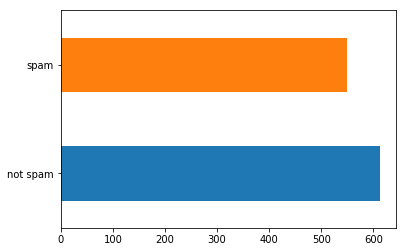

In [20]:
df_clean['Class'].value_counts().plot(kind='barh');

#### 2.2.2 Class vs Length Distribution

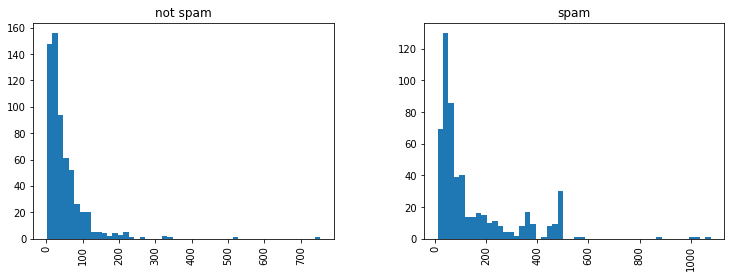

In [21]:
df_clean.hist(column='length', by='Class', bins=50, figsize=(12,4));

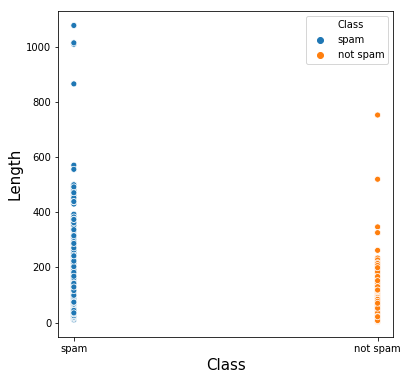

In [22]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='Class', 
                y='length', 
                hue='Class',
                data=df_clean);
plt.xlabel('Class',size=15)
plt.ylabel('Length', size =15)
plt.show()

In [23]:
df_clean.groupby('Class').describe()

length                                                          
          count        mean         std   min   25%   50%     75%     max
Class                                                                    
not spam  612.0   49.106209   57.560501   2.0  18.0  33.0   62.25   753.0
spam      550.0  144.387273  159.629207  10.0  40.0  70.5  189.50  1078.0

**Spam comments have higher means of length**

## 3. Data Modelling & Prediction

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report

# suppress bs4 warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df_clean['Comment'], df_clean['Class'], test_size=0.2)

x_train.to_csv('data/03_processed/x_train.csv', header=False)
y_train.to_csv('data/03_processed/y_train.csv', header=False)
x_test.to_csv('data/03_processed/x_test.csv', header=False)
y_test.to_csv('data/03_processed/y_test.csv', header=False)

### 3.1 Logistic Regression

In [26]:
reglog_pipe = Pipeline([
    ('bow', CountVectorizer()), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(solver='liblinear', multi_class='auto')) # train on TF-IDF vectors w/ SGD classifier
])

reglog_pipe.fit(x_train, y_train);

#### 3.1.1 Prediction

In [27]:
reglog_predictions = reglog_pipe.predict(x_test);

In [28]:
reglog_report = classification_report(y_test, reglog_predictions)
print(reglog_report)

              precision    recall  f1-score   support

    not spam       0.91      0.97      0.94       114
        spam       0.97      0.91      0.94       119

   micro avg       0.94      0.94      0.94       233
   macro avg       0.94      0.94      0.94       233
weighted avg       0.94      0.94      0.94       233



#### 3.1.2 Confusion Matrix

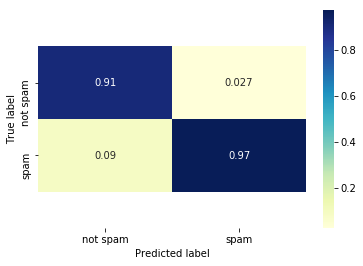

In [29]:
cm = confusion_matrix(y_test, reglog_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['not spam','spam'], 
                     columns = ['not spam','spam'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.2 Multinomial Naive Bayes

In [30]:
nb_pipe = Pipeline([
    ('bow', CountVectorizer()), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()) # train on TF-IDF vectors w/ Naive Bayes classifier
])

nb_pipe.fit(x_train, y_train)
nb_train_score = nb_pipe.score(x_train, y_train)
nb_test_score = nb_pipe.score(x_test, y_test)

#### 3.2.1 Prediction

In [31]:
nb_predictions = nb_pipe.predict(x_test);

In [32]:
nb_report = classification_report(y_test, nb_predictions)
print(nb_report)

              precision    recall  f1-score   support

    not spam       0.91      0.96      0.93       114
        spam       0.96      0.91      0.93       119

   micro avg       0.93      0.93      0.93       233
   macro avg       0.93      0.93      0.93       233
weighted avg       0.93      0.93      0.93       233



#### 3.2.2 Confusion Matrix

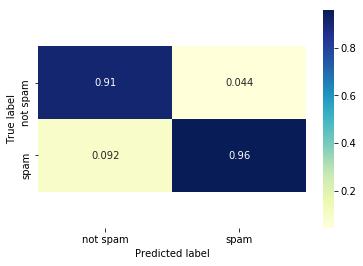

In [33]:
cm = confusion_matrix(y_test, nb_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['not spam','spam'], 
                     columns = ['not spam','spam'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.3 Random Forest Classifier

In [34]:
rf_pipe = Pipeline([
    ('bow', CountVectorizer()), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=-1)) # train on TF-IDF vectors w/ Random Forest classifier
])

rf_pipe.fit(x_train, y_train);

#### 3.3.1 Prediction

In [35]:
rf_predictions = rf_pipe.predict(x_test);

In [36]:
rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

              precision    recall  f1-score   support

    not spam       0.91      0.95      0.93       114
        spam       0.95      0.91      0.93       119

   micro avg       0.93      0.93      0.93       233
   macro avg       0.93      0.93      0.93       233
weighted avg       0.93      0.93      0.93       233



#### 3.3.2 Confusion Matrix

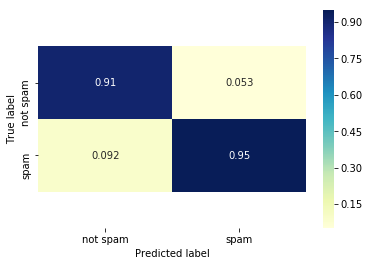

In [37]:
cm = confusion_matrix(y_test, rf_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['not spam','spam'], 
                     columns = ['not spam','spam'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.4 Stochastic Gradient Descent

In [38]:
sgd_pipe = Pipeline([
    ('bow', CountVectorizer()), # strings to token integer counts
    ('tfidf', TfidfTransformer()), # integer counts to weighted TF-IDF scores
    ('classifier', SGDClassifier(max_iter=1000, tol=1e-3)) # train on TF-IDF vectors w/ SGD classifier
])

sgd_pipe.fit(x_train, y_train);

#### 3.4.1 Prediction

In [39]:
sgd_predictions = sgd_pipe.predict(x_test);

In [40]:
sgd_pipe.predict(x_train);
print(classification_report(y_train, sgd_pipe.predict(x_train)))

              precision    recall  f1-score   support

    not spam       1.00      1.00      1.00       498
        spam       1.00      1.00      1.00       431

   micro avg       1.00      1.00      1.00       929
   macro avg       1.00      1.00      1.00       929
weighted avg       1.00      1.00      1.00       929



In [41]:
sgd_report = classification_report(y_test, sgd_predictions)
print(sgd_report)

              precision    recall  f1-score   support

    not spam       0.97      0.97      0.97       114
        spam       0.97      0.97      0.97       119

   micro avg       0.97      0.97      0.97       233
   macro avg       0.97      0.97      0.97       233
weighted avg       0.97      0.97      0.97       233



#### 3.4.2 Confusion Matrix

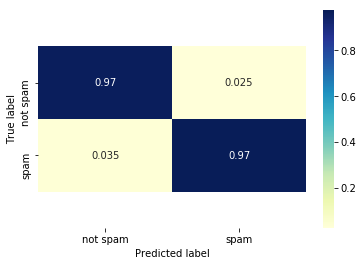

In [42]:
cm = confusion_matrix(y_test, sgd_predictions)

cm = cm/cm.astype(np.float).sum(axis=0)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['not spam','spam'], 
                     columns = ['not spam','spam'])

ax = sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### 3.5 Summary

In [43]:
print('---------------------------------------')
print('Logistic Regression Result')
print('---------------------------------------')
print(reglog_report)
print()
print('---------------------------------------')
print('Naive Bayes Result')
print('---------------------------------------')
print(nb_report)
print()
print('---------------------------------------')
print('Random Forest Classification Result')
print('---------------------------------------')
print(rf_report)
print()
print('---------------------------------------')
print('Stochastic Gradient Descent Result')
print('---------------------------------------')
print(sgd_report)

---------------------------------------
Logistic Regression Result
---------------------------------------
              precision    recall  f1-score   support

    not spam       0.91      0.97      0.94       114
        spam       0.97      0.91      0.94       119

   micro avg       0.94      0.94      0.94       233
   macro avg       0.94      0.94      0.94       233
weighted avg       0.94      0.94      0.94       233


---------------------------------------
Naive Bayes Result
---------------------------------------
              precision    recall  f1-score   support

    not spam       0.91      0.96      0.93       114
        spam       0.96      0.91      0.93       119

   micro avg       0.93      0.93      0.93       233
   macro avg       0.93      0.93      0.93       233
weighted avg       0.93      0.93      0.93       233


---------------------------------------
Random Forest Classification Result
---------------------------------------
              precisio

## 4. Conclusion
On average our models are about **93.5% accurate**. While this may mean that the machine cannot predict every comments with 100% accuracy. It can really depend on the data and how it has been processed.

Out of the 4 used in this project, the most **accurate and precise was the Stochastic Gradient Descent (SGD)**, with accuracy of 95%.

SGD **highest recall**, with recall score 93%. This means that the SGD actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).

SGD has the **highest F1 score**, with f1 score 94%, which means that it defines a relationship between Recall and Precision of a particular model. F1 Scores might be a better measure to use if we need to seek a balance between Precision and Recall and if there is an uneven class distribution (a large number of Actual Negatives).

In [44]:
df_output = pd.DataFrame(x_test.copy())
df_output['Class'] = y_test
df_output['Prediction'] = sgd_predictions

In [45]:
df_output.to_csv('data/04_model_output/sgd_output.csv')